In [ ]:
import torch as tor
import torch.nn as nn
import torch.utils.data
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from google.colab import drive
from skimage.measure import compare_ssim
from skimage.measure import compare_psnr
import math


In [ ]:
drive.mount('/content/gdrive')
%cd "/content/gdrive/My Drive/codecode/code/"
!pip install import-ipynb
import import_ipynb
import basicblock as B
from utils import utils_logger
#from utils import utils_model
from utils import utils_image as util
#import network_dncnn as dncnn
#from network_dncnn import IRCNN

#from network_dncnn import IRCNN as net

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/codecode/code


In [ ]:
class FFDNet(nn.Module):
    def __init__(self, in_nc=1, out_nc=1, nc=64, nb=15, act_mode='R'):
        """
        # ------------------------------------
        in_nc: channel number of input
        out_nc: channel number of output
        nc: channel number
        nb: total number of conv layers
        act_mode: batch norm + activation function; 'BR' means BN+ReLU.
        # ------------------------------------
        # ------------------------------------
        """
        super(FFDNet, self).__init__()
        assert 'R' in act_mode or 'L' in act_mode, 'Examples of activation function: R, L, BR, BL, IR, IL'
        bias = True
        sf = 2

        self.m_down = B.PixelUnShuffle(upscale_factor=sf)

        m_head = B.conv(in_nc*sf*sf+1, nc, mode='C'+act_mode[-1], bias=bias)
        m_body = [B.conv(nc, nc, mode='C'+act_mode, bias=bias) for _ in range(nb-2)]
        m_tail = B.conv(nc, out_nc*sf*sf, mode='C', bias=bias)

        self.model = B.sequential(m_head, *m_body, m_tail)

        self.m_up = nn.PixelShuffle(upscale_factor=sf)

    def forward(self, x, sigma):

        h, w = x.size()[-2:]
        paddingBottom = int(np.ceil(h/2)*2-h)
        paddingRight = int(np.ceil(w/2)*2-w)
        x = torch.nn.ReplicationPad2d((0, paddingRight, 0, paddingBottom))(x)

        x = self.m_down(x)
        # m = torch.ones(sigma.size()[0], sigma.size()[1], x.size()[-2], x.size()[-1]).type_as(x).mul(sigma)
        m = sigma.repeat(1, 1, x.size()[-2], x.size()[-1])
        x = torch.cat((x, m), 1)
        x = self.model(x)
        x = self.m_up(x)
        
        x = x[..., :h, :w]
        return x

In [ ]:
device = tor.device("cuda:0" if tor.cuda.is_available() else "cpu")
model25 = tor.load('/content/gdrive/My Drive/codecode/model/ffdnet_gray.pth')
model = FFDNet()
model.load_state_dict(model25, strict=True)
model.eval()
model = model.to(device)

In [ ]:
#testdir = root1 + 'test/'
testdir = '/content/gdrive/My Drive/codecode/img/test/'
test_psnrs = []
test_ssims = []

for i in range(0,54):
  img_L = imread_uint(testdir+'img_'+str(i+1)+'.png',n_channels=1)
  ssim_L = 0
  psnr_L = 0
  img_L = uint2single(img_L)
  #print("Original image")
  #plt.imshow(np.squeeze(single2uint(img_L)), interpolation='nearest', cmap='gray')
  img_L = single2tensor4(img_L)
  img_L = img_L.to(device)
  sigma = torch.full((1,1,1,1), 15/255.).type_as(img_L)
  clean_img = model(img_L,sigma)
  clean_img = tensor2uint(clean_img)
  noisy_cal= imread_uint(testdir+'img_'+str(i+1)+'.png', n_channels=1)
  noisy_cal= noisy_cal.squeeze()
  ssim_L = calculate_ssim(clean_img,noisy_cal,border=0)
  psnr_L = calculate_psnr(clean_img,noisy_cal,border=0)
  #print("Denoised image")
  #plt.imshow(np.squeeze(noisy_cal), interpolation='nearest', cmap='gray')

  print("Calculate FFDnet denoised image and original image")
  test_ssims.append(ssim_L)
  test_psnrs.append(psnr_L)
  
  
test_psnr = np.mean(test_psnrs)
test_ssim = np.mean(test_ssims)
print("mean psnr: ",test_psnr)
print("mean ssim: ",test_ssim)

Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image and original image
Calculate FFDnet denoised image

In [ ]:
img_L = imread_uint('/content/gdrive/My Drive/codecode/img/img_49.png',n_channels=1)
img_L = uint2single(img_L)
#print("Original image")
#plt.imshow(np.squeeze(single2uint(img_L)), interpolation='nearest', cmap='gray')
img_L = single2tensor4(img_L)
img_L = img_L.to(device)


ssim:  0.82093465926959
psnr:  31.786436514698472
Denoised image


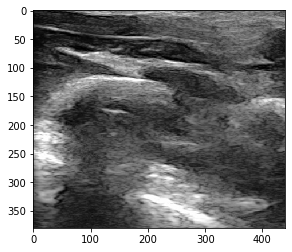

In [ ]:
sigma = torch.full((1,1,1,1), 15/255.).type_as(img_L)
clean_img = model(img_L,sigma)
clean_img = tensor2uint(clean_img)
noisy_cal= imread_uint('/content/gdrive/My Drive/codecode/img/img_49.png', n_channels=1)
noisy_cal= noisy_cal.squeeze()
print("ssim: ",calculate_ssim(clean_img,noisy_cal,border=0))
print("psnr: ",calculate_psnr(clean_img,noisy_cal,border=0))
print("Denoised image")
plt.imshow(np.squeeze(noisy_cal), interpolation='nearest', cmap='gray')

True

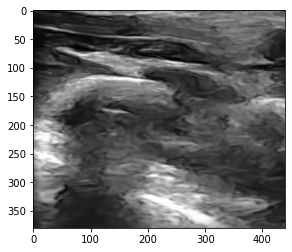

In [ ]:
plt.imshow(clean_img,cmap="gray")
cv2.imwrite('/content/gdrive/My Drive/codecode/result/img_49_test.png', clean_img)